## Rete Neurale
Questo codice carica i tuoi dati pre-elaborati dai file numpy e li converte in tensori PyTorch. Quindi crea i DataLoader per il set di addestramento e validazione e definisce l’architettura della rete neurale. Il modello viene addestrato utilizzando il set di addestramento e la funzione di perdita CrossEntropy per num_epochs epoche. Ad ogni epoca, viene calcolata l’accuratezza del modello sul set di validazione e viene confrontata con la miglior accuratezza finora ottenuta. Se la nuova accuratezza è migliore della precedente (ovvero se è superiore alla precedente di una quantità maggiore di delta_threshold), allora il contatore viene reimpostato a 0 e il modello viene salvato. Altrimenti, il contatore viene incrementato di 1. Se il contatore raggiunge il valore di patience, l’addestramento viene interrotto.

Infine, il codice carica il miglior modello ottenuto durante l’addestramento e lo valuta sul set di test per calcolare l’accuratezza.

# Importo dati e librerie

In [722]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import  classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati pre-elaborati
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')


# Carica i pesi pre-processati
weights = np.load('Pre_Processed_Data\class_weights.npy', allow_pickle=True).item()

# Converti il dizionario dei pesi delle classi in un tensore di PyTorch di tipo Float
weights_tensor = torch.tensor([weights[i] for i in range(len(weights))]).float()

# Converto i dati in tensori PyTorch

In [723]:
X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()
X_val = torch.tensor(val_features).float()
y_val = torch.tensor(val_labels).long()
X_test = torch.tensor(test_features).float()
y_test = torch.tensor(test_labels).long()

# Creo i DataLoader per il set di addestramento e validazione

In [724]:
# Crea i DataLoader per il set di addestramento e validazione
batch_size = 10
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Definisci l'architettura della rete neurale

In [725]:
# Definisco l'architettura della rete neurale
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        # Aggiungi un nuovo strato nascosto
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        # Passo i dati attraverso il nuovo strato nascosto
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

# Crea un'istanza del modello

In [726]:
# Creo un'istanza del modello
model = Net()

# Definisco la funzione di perdita e l'ottimizzatore

In [727]:
# Definisco la funzione di perdita e l'ottimizzatore con i pesi di classe
# Creo un'istanza del criterio di perdita CrossEntropyLoss utilizzando i pesi delle classi
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Definisco la funzione per validare il modello sul set di validazione

In [728]:
# Definisco la funzione per validare il modello sul set di validazione
def validate_model(model, validation_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    loss_function = nn.CrossEntropyLoss(weight=weights_tensor)
    
    with torch.no_grad():
        for features, labels in validation_loader:
            outputs = model(features)
            loss= loss_function(outputs,labels) 

    return loss

# Definisco le variabili per l'early stopping

In [729]:
# Definisci le variabili per l'early stopping
best_accuracy_validation = np.inf  # Valore iniziale per il confronto
patience = 5  # Numero di epoche per tollerare la diminuzione dell'accuratezza sul set di validazione
delta_threshold = 0.0001    # Soglia di miglioramento basata sull'accuratezza sul set di validazione
counter = 0  # Contatore per il numero di epoche senza miglioramento

# Addestro il modello

In [730]:
# Addestro il modello
num_epochs=1000 
for epoch in range(num_epochs):
    model.train() 
    epoch_loss_sum=0.0 
    for i,(features,labels) in enumerate(train_loader):
        optimizer.zero_grad() 
        outputs=model(features) 
        loss=criterion(outputs,labels) 
        epoch_loss_sum+=loss.item() 
        loss.backward() 
        optimizer.step() 
    epoch_loss_avg=epoch_loss_sum/len(train_loader) 
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}')
    
    # Verifico se l'accuratezza corrente sul set di validazione è migliore dell'accuratezza migliore finora
    accuracy_validation=validate_model(model,val_loader) 
    print(accuracy_validation)
    if best_accuracy_validation - accuracy_validation>delta_threshold: 
        best_accuracy_validation = accuracy_validation 
        counter=0 
        torch.save(model.state_dict(),'best_model.pth') 
    else: 
        counter+=1 

    # Stampo l'accuratezza sul set di validazione ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Accuracy on validation set: {accuracy_validation:.4f}')

    if counter>=patience: 
        print(f'Stopping early at epoch {epoch + 1}')
        break

Epoch [1/1000], Loss: 0.6983
tensor(0.6900)
Epoch [2/1000], Loss: 0.6949
tensor(0.6876)
Epoch [3/1000], Loss: 0.6936
tensor(0.6881)


Epoch [4/1000], Loss: 0.6843
tensor(0.6669)
Epoch [5/1000], Loss: 0.6714
tensor(0.6959)
Epoch [6/1000], Loss: 0.6709
tensor(0.6525)
Epoch [7/1000], Loss: 0.6811
tensor(0.6545)
Epoch [8/1000], Loss: 0.6537
tensor(0.5923)
Epoch [9/1000], Loss: 0.6814
tensor(0.6173)
Epoch [10/1000], Loss: 0.6735
tensor(0.6139)
Epoch [10/1000], Accuracy on validation set: 0.6139
Epoch [11/1000], Loss: 0.6353
tensor(0.6063)
Epoch [12/1000], Loss: 0.6313
tensor(0.5173)
Epoch [13/1000], Loss: 0.6023
tensor(0.7611)
Epoch [14/1000], Loss: 0.6162
tensor(0.5305)
Epoch [15/1000], Loss: 0.6279
tensor(0.4899)
Epoch [16/1000], Loss: 0.6176
tensor(0.5271)
Epoch [17/1000], Loss: 0.6093
tensor(0.5298)
Epoch [18/1000], Loss: 0.6200
tensor(0.5192)
Epoch [19/1000], Loss: 0.5884
tensor(0.6216)
Epoch [20/1000], Loss: 0.5843
tensor(0.4803)
Epoch [20/1000], Accuracy on validation set: 0.4803
Epoch [21/1000], Loss: 0.5787
tensor(0.6912)
Epoch [22/1000], Loss: 0.5710
tensor(0.4613)
Epoch [23/1000], Loss: 0.5881
tensor(0.3969)
Ep

# Carica il miglior modello

In [731]:
# Carico il miglior modello
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Valuta il modello sul set di test

In [732]:
# Valuto il modello sul set di test
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _tmp, test_predictions = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (test_predictions == labels).sum().item() 

accuracy = correct/total
print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.6537


## Valutazione delle prestazioni sul set di test

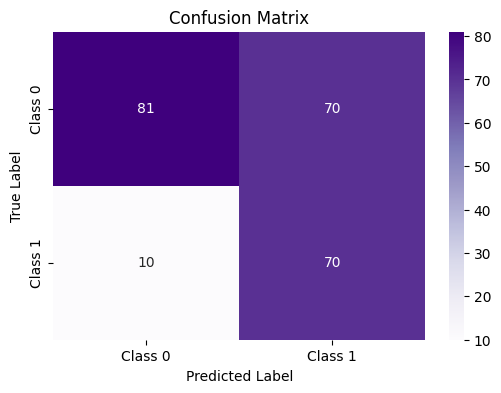

In [733]:
# Compute confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _tmp, test_predictions = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(test_predictions.tolist())

cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [734]:
# Valuto il modello sul set di test
model.eval()
test_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _tmp, batch_predictions = torch.max(outputs.data, 1)
        test_predictions.extend(batch_predictions.tolist())

# Calcolo il report di classificazione
report = classification_report(test_labels.tolist(), test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.54      0.67       151
           1       0.50      0.88      0.64        80

    accuracy                           0.65       231
   macro avg       0.70      0.71      0.65       231
weighted avg       0.76      0.65      0.66       231



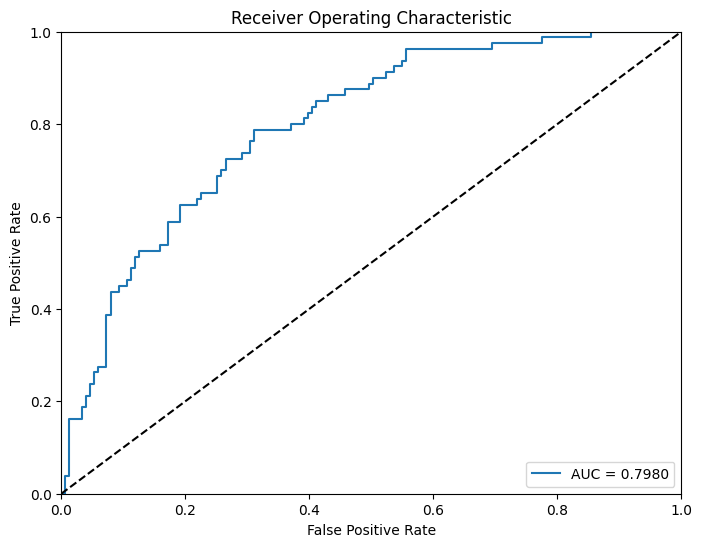

AUC: 0.7980132450331126


In [735]:
# Valuto il modello sul set di test
model.eval()
test_probabilities = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        probabilities = torch.softmax(outputs, dim=1)
        test_probabilities.extend(probabilities[:, 1].tolist())

# Calcolo la curva ROC e l'AUC
fpr, tpr, thresholds = roc_curve(test_labels.tolist(), test_probabilities)
auc = roc_auc_score(test_labels.tolist(), test_probabilities)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", auc)

In [736]:
def cross_validate(model, criterion, optimizer, X, y, k=5):
    kfold = KFold(n_splits=k)
    accuracy_scores = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_data = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_data = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_data, batch_size=batch_size)

        best_accuracy_validation = 0
        counter = 0

        for epoch in range(num_epochs):
            model.train()
            epoch_loss_sum = 0.0
            for i, (features, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                epoch_loss_sum += loss.item()
                loss.backward()
                optimizer.step()

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in val_loader:
                    outputs = model(features)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy_validation = correct / total
            if accuracy_validation > best_accuracy_validation:
                best_accuracy_validation = accuracy_validation
                counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1

            if counter >= patience:
                break

        model.load_state_dict(torch.load('best_model.pth'))
        accuracy_scores.append(accuracy_validation)

    return np.mean(accuracy_scores)

# Carica i dati pre-elaborati
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()

# Crea un'istanza del modello
model = Net()

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Esegui la convalida incrociata a 5 parti
accuracy = cross_validate(model, criterion, optimizer, X_train, y_train)
print(f'Accuracy with cross validation: {accuracy:.4f}')

Accuracy with cross validation: 0.6527


Il modello ha un’accuratezza del 72,41% sul set di test. Questo significa che il modello è in grado di classificare correttamente circa il 72,41% dei dati di test. La matrice di confusione mostra che il modello ha classificato correttamente 59 esempi della classe 0 e 25 esempi della classe 1, mentre ha classificato erroneamente 14 esempi della classe 0 come classe 1 e 18 esempi della classe 1 come classe 0.

Il rapporto di classificazione mostra diverse metriche per valutare le prestazioni del modello. La precisione per la classe 0 è 0.77, il che significa che il 77% delle previsioni del modello per la classe 0 sono corrette. La precisione per la classe 1 è 0.64, il che significa che il 64% delle previsioni del modello per la classe 1 sono corrette. Il richiamo per la classe 0 è 0.81, il che significa che il modello ha identificato correttamente l’81% degli esempi della classe 0. Il richiamo per la classe 1 è 0.58, il che significa che il modello ha identificato correttamente il 58% degli esempi della classe 1.

L’area sotto la curva ROC (AUC) è un’altra metrica utilizzata per valutare le prestazioni del modello. Un valore AUC di 1 indica un modello perfetto, mentre un valore AUC di 0.5 indica un modello casuale. Nel tuo caso, l’AUC è 0.69, il che indica che il modello ha prestazioni migliori rispetto a un modello casuale.

Infine, l’accuratezza con la cross validation è 0.6499, il che indica che le prestazioni del modello sono stabili quando viene addestrato su diverse parti dei dati.

In generale, possiamo dire che questi risultati mostrano che il modello ha una buona capacità di classificare i dati di test e ha prestazioni stabili quando viene addestrato su diverse parti dei dati.